In [1]:
import requests
import pytz

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,9)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

from IPython.display import display

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rtem-preprocessed/metadata_44342.csv
/kaggle/input/rtem-preprocessed/metadata_44390.csv
/kaggle/input/rtem-preprocessed/metadata-2.csv
/kaggle/input/multifamily/multifamily.csv
/kaggle/input/multifamily/multifamily-2.csv
/kaggle/input/multifamily/multifamily-4.csv
/kaggle/input/multifamily/multifamily-3.csv
/kaggle/input/ny-counties/counties01.csv


In [2]:
county_num = pd.read_csv('/kaggle/input/ny-counties/counties01.csv')
county_num

,number,county_name
0,0,Albany County
1,1,Allegany County
2,2,Bronx County
3,3,Broome County
4,4,Cattaraugus County
...,...,...
57,57,Washington County
58,58,Wayne County
59,59,Westchester County
60,60,Wyoming County


In [3]:
metadata = pd.read_csv('/kaggle/input/rtem-preprocessed/metadata-2.csv')
metadata;

In [4]:
multifam = pd.read_csv('/kaggle/input/multifamily/multifamily-4.csv')
county_stats = multifam.groupby('county').sum()[['equip_count','point_count','sq_ft']]
county_stats = county_stats.reset_index()

# map county vs county number
# county_num[county_num.county_name.str.contains('Westchester')]
df = county_stats
df['county_number'] = df['county'].copy()
df['county_number'] = df['county_number'].map({'bronx':2,'kings':23,'new york':30,'queens':40,'westchester':59})
df = df[['county_number', 'county', 'equip_count','point_count','sq_ft']]
df;

In [5]:
multifam['county_number'] = multifam['county'].map({'bronx':2,'kings':23,'new york':30,'queens':40,'westchester':59})
multifam;

In [6]:
multifam[multifam.county=='bronx'].equip_type_name.value_counts()

Site Sensors         1276
Boiler                404
Virtual               199
Hot Water Plant       172
Pump                   63
Meter                  12
Fan                     6
Heat Exchanger          4
Air Handling Unit       2
Name: equip_type_name, dtype: int64

In [7]:
# equipement count per county
equip_count = pd.pivot_table(multifam[['county','equip_type_name','borough']], values = 'borough', index='county',columns='equip_type_name',aggfunc='count').fillna(0)
equip_count = equip_count.reset_index()
equip_count

equip_type_name,county,Air Handling Unit,Battery,Boiler,Chilled Water Plant,Chiller,Condenser,Cooling Tower,Duct Heater,Electrical Panel,...,Fan Coil Unit,Heat Exchanger,Heat Pump,Hot Water Plant,Lighting System,Meter,Pump,Site Sensors,Tank,Virtual
0,bronx,2.0,0.0,404.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,172.0,0.0,12.0,63.0,1276.0,0.0,199.0
1,kings,40.0,10.0,107.0,0.0,0.0,18.0,0.0,0.0,48.0,...,2.0,0.0,0.0,24.0,10.0,32.0,47.0,279.0,0.0,24.0
2,new york,2.0,51.0,269.0,49.0,8.0,1.0,11.0,1.0,7.0,...,7.0,8.0,0.0,53.0,10.0,274.0,55.0,376.0,0.0,490.0
3,queens,0.0,0.0,31.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,6.0,7.0,40.0,0.0,42.0,10.0,661.0,0.0,79.0
4,westchester,0.0,0.0,158.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,0.0,23.0,11.0,99.0,8.0,35.0


In [8]:
df1 = pd.merge(df, equip_count, on='county', how='inner')
df1_num = df1.select_dtypes(np.number).astype(int)
df1_cat = df1.select_dtypes('object')
county_equipment_counts_multifamily = df1_cat.join(df1_num)

In [9]:
county_equipment_counts_multifamily

,county,county_number,equip_count,point_count,sq_ft,Air Handling Unit,Battery,Boiler,Chilled Water Plant,Chiller,...,Fan Coil Unit,Heat Exchanger,Heat Pump,Hot Water Plant,Lighting System,Meter,Pump,Site Sensors,Tank,Virtual
0,bronx,2,31661,1762590,908293027,2,0,404,0,0,...,0,4,0,172,0,12,63,1276,0,199
1,kings,23,36713,112693,342457605,40,10,107,0,0,...,2,0,0,24,10,32,47,279,0,24
2,new york,30,64989,202124,658500738,2,51,269,49,8,...,7,8,0,53,10,274,55,376,0,490
3,queens,40,68100,318574,354486671,0,0,31,0,0,...,0,6,7,40,0,42,10,661,0,79
4,westchester,59,2691,18941,35174200,0,0,158,0,0,...,0,0,0,12,0,23,11,99,8,35


In [10]:
county_equipment_counts_multifamily.to_csv('county_equipment_counts_multifamily.csv')

In [11]:
metadata.equip_type_name.unique()

array(['Boiler', 'Pump', 'Hot Water Plant', 'Site Sensors', 'Virtual',
       'Meter', 'Air Handling Unit', 'Chilled Water Plant', 'Chiller',
       'Lighting System', 'Condenser', 'Heat Exchanger', 'Cooling Tower',
       'Fan', 'Variable Air Volume', 'Fan Coil Unit', 'Heat Pump',
       'Dry Cooler', 'Electrical Panel', 'Tank', 'Unit Ventilator',
       'Elevator', 'Duct Heater', 'Radiant System', 'Battery',
       'Variable Refrigerant Flow'], dtype=object)

In [12]:
equip_cols = ['Boiler', 'Pump', 'Hot Water Plant', 'Site Sensors', 'Virtual',
       'Meter', 'Air Handling Unit', 'Chilled Water Plant', 'Chiller',
       'Lighting System', 'Condenser', 'Heat Exchanger', 'Cooling Tower',
       'Fan', 'Variable Air Volume', 'Fan Coil Unit', 'Heat Pump',
       'Dry Cooler', 'Electrical Panel', 'Tank', 'Unit Ventilator',
       'Elevator', 'Duct Heater', 'Radiant System', 'Battery',
       'Variable Refrigerant Flow']

In [13]:
equip_cols_list = county_equipment_counts_multifamily.columns.drop(['county','county_number','equip_count','point_count','sq_ft'])
equip_cols_list

Index(['Air Handling Unit', 'Battery', 'Boiler', 'Chilled Water Plant',
       'Chiller', 'Condenser', 'Cooling Tower', 'Duct Heater',
       'Electrical Panel', 'Elevator', 'Fan', 'Fan Coil Unit',
       'Heat Exchanger', 'Heat Pump', 'Hot Water Plant', 'Lighting System',
       'Meter', 'Pump', 'Site Sensors', 'Tank', 'Virtual'],
      dtype='object')

In [14]:
tmp = county_equipment_counts_multifamily.drop(columns=['county_number','equip_count','point_count','sq_ft'])
tmp = tmp.groupby('county').sum()

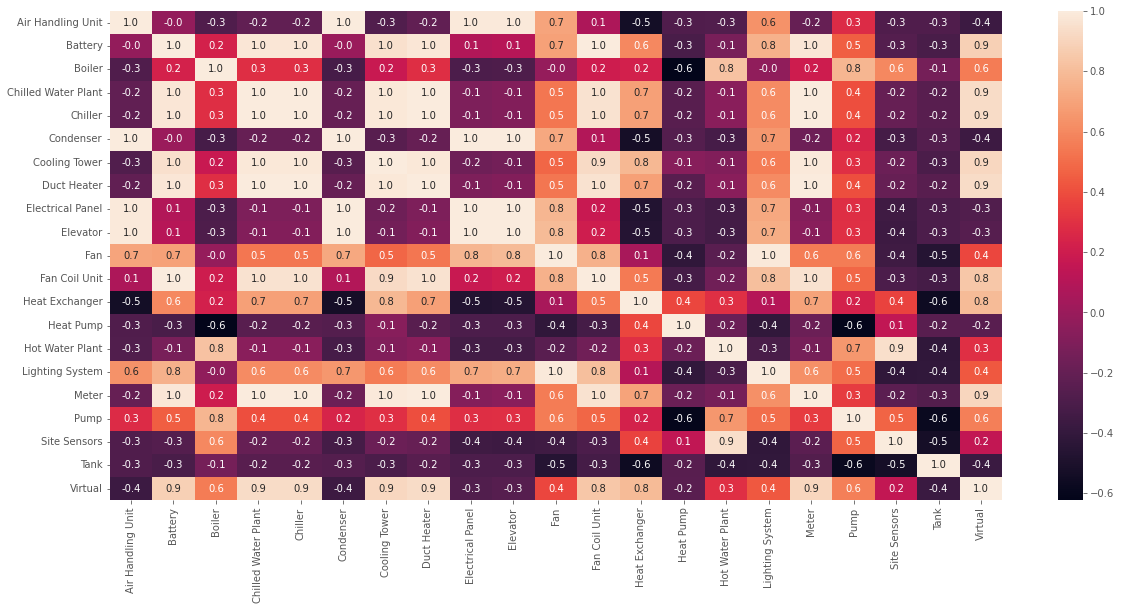

In [15]:
sns.heatmap(tmp.corr(),annot=True, fmt='.1f')
plt.show()

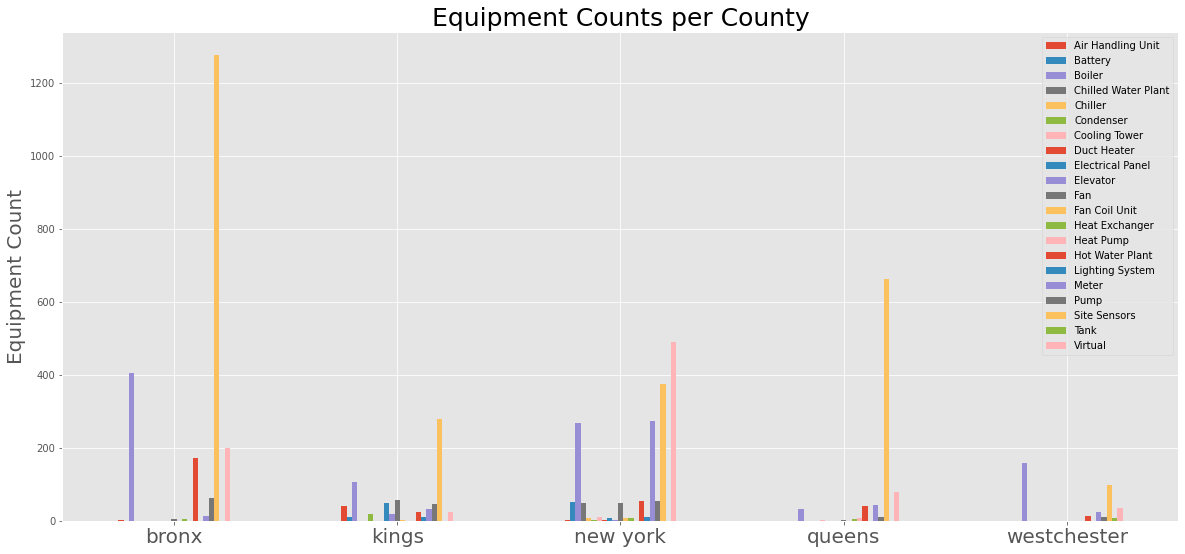

In [16]:
tmp.plot(kind='bar')
plt.xticks(rotation=360, fontsize=20)
plt.xlabel('')
plt.ylabel('Equipment Count', fontsize=20)
plt.title('Equipment Counts per County', fontsize=25)
# plt.legend([],[], frameon=False)
plt.show()

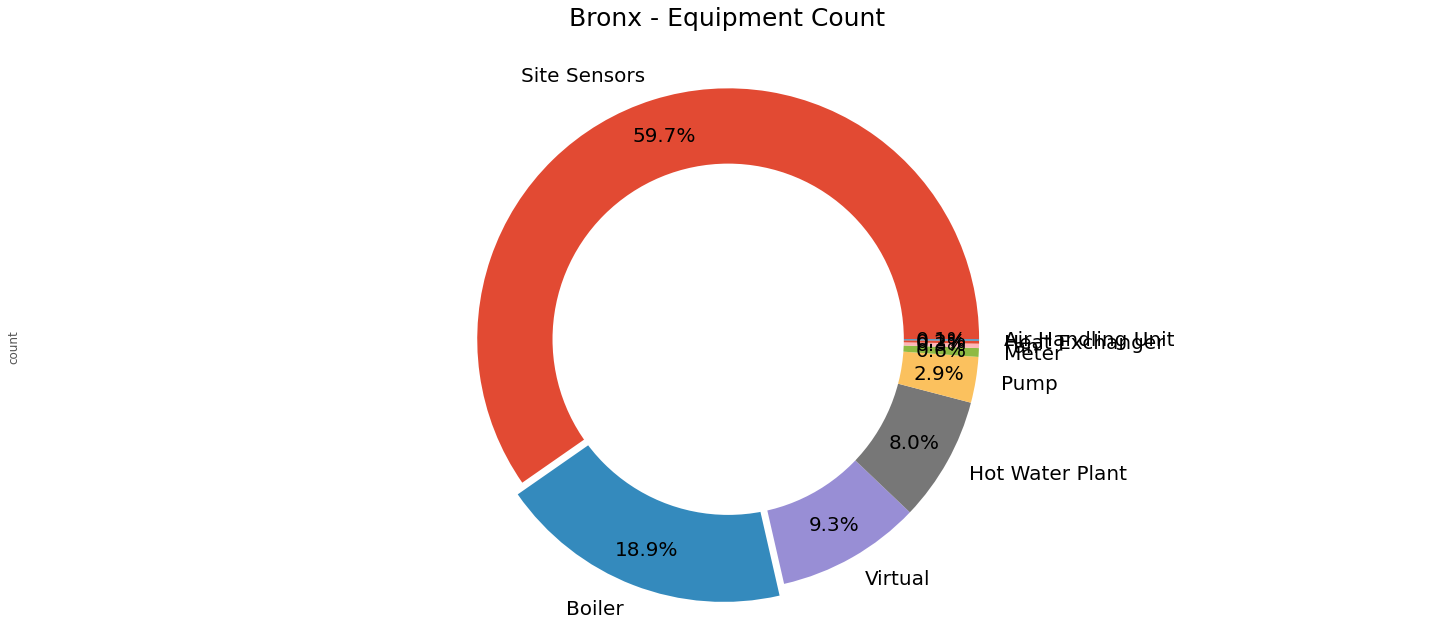

In [17]:
#bronx
myexplode = [0, 0.05, 0, 0, 0, 0, 0, 0, 0]

tmp1 = tmp[tmp.index=='bronx'].melt().sort_values('value',ascending=False)
tmp2 = tmp1[tmp1.value >0]
tmp2 = tmp2.rename(columns={'variable':'equip_type','value':'count'}).set_index('equip_type')

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)

tmp2.plot(kind='pie', subplots=True, explode = myexplode, pctdistance=0.85, autopct='%1.1f%%', fontsize=20)

plt.title('Bronx - Equipment Count\n', size=25)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()